In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset




from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
%matplotlib inline

In [2]:
pl.seed_everything(42, workers=True)
validation_split = 0.3
shuffle_dataset  = True
batch_size = 64
max_epochs = 60
input_size = 33

Global seed set to 42


In [3]:
def load_transaction(only_fraud=False):
    df = pd.read_csv("transaction_dataset.csv")

    #Rename columns for easier access
    df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()

    #Remove weird stuff 
    df.drop(columns=['unnamed:_0'], inplace=True)

    #Remove duplicate accounts
    df.drop_duplicates(subset=['address'], inplace=True)

    #Remove accounts 
    df.drop(columns=['address'], inplace=True)

    #Remove index
    df.drop(columns=['index'], inplace=True)

    #Remove token names 
    df.drop(columns=['erc20_most_sent_token_type','erc20_most_rec_token_type'], inplace = True)

    #Remove var=0 columns
    df.drop(df.var(numeric_only=True)[df.var(numeric_only=True) == 0].index, axis = 1, inplace = True)

    #Remove small distribution columns
    small_distr_col = []
    for col in df.columns[3:] :
        if df[col].nunique() < 10:
            small_distr_col.append(col)
    df.drop(columns=small_distr_col,inplace = True)
    
    # Remove negative values 
    df[df<0] = None 
    df.dropna(inplace=True)
    
    if(only_fraud):
        df.drop(df[df['flag'] == 0].index, inplace = True)
    
    return df


def train_test_split_indices(length, validation_split, shuffle_dataset = True, random_seed = 42):
    # Creating data indices for training and validation splits.
    indices = np.arange(length)
    validation_size = int(validation_split * length)
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[validation_size:], indices[:validation_size]
    return train_indices, val_indices

class MyDataset(Dataset):
    def __init__(self, df, indices, augment = False, 
                 cols_median = None, cols_means = None, cols_std = None):
        super().__init__()
        self.augment = augment
        
        df = df.iloc[indices].copy()
        
        if(self.augment):
            oversample = SMOTE()
            df,y = oversample.fit_resample(df.iloc[:,1:],df.values[:,0])
        else: 
            y,df  = df.values[:, 0],df.iloc[:, 1:]
        
        if any(param is None for param in [cols_median, cols_means, cols_std]):
            self.cols_median = df.median(numeric_only=True)
            self.cols_means  = df.mean  (numeric_only=True)
            self.cols_std    = df.std   (numeric_only=True)
        else:
            self.cols_median = cols_median
            self.cols_means  = cols_means
            self.cols_std    = cols_std
            
        df.fillna(self.cols_median, inplace = True)
        df = (df - self.cols_means) / self.cols_std
        
        self.y = y
        self.X = df.values                                    
        
    def get_cols_stats(self):
        return self.cols_median, self.cols_means, self.cols_std
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.augment:
            pass
        
        return x, y
class MyDataModule(pl.LightningDataModule):
    def __init__(self, df, batch_size, train_indices, val_indices,augment):
        super().__init__()
        self.df = df
        self.batch_size = batch_size
        self.train_indices = train_indices
        self.val_indices = val_indices
        self.augment = augment
    def get_stats(self):
        return self.train_set.get_cols_stats()
    
    def setup(self, stage = None):
        self.train_set = MyDataset(self.df, self.train_indices, augment = self.augment)
        
        train_cols_median, train_cols_means, train_cols_std = self.train_set.get_cols_stats()
        
        self.val_set = MyDataset(self.df, self.val_indices,
                                 augment = False,
                                 cols_median = train_cols_median,
                                 cols_means  = train_cols_means,
                                 cols_std    = train_cols_std)
          
    def train_dataloader(self):
        return DataLoader(self.train_set,
                          batch_size = self.batch_size,
                          shuffle = True,
                          num_workers = 8,
                          pin_memory = True)
    def val_dataloader(self):
        return DataLoader(self.val_set,
                          batch_size = self.batch_size,
                          shuffle = False,
                          num_workers = 8,
                          pin_memory = True)


In [4]:
def train(model,only_fraud=False,augment=False,validation_split=validation_split,
          shuffle_dataset=False,batch_size=batch_size,
         max_epochs=max_epochs,input_size=input_size):

    df = load_transaction(only_fraud=only_fraud)


    train_indices, val_indices = train_test_split_indices(length = len(df),
                                                      validation_split = validation_split)        

    data = MyDataModule(df,
                        train_indices = train_indices,
                        val_indices   = val_indices,
                        batch_size    = batch_size,
                        augment       = augment)
    early_stopping = EarlyStopping('acc',patience=100,mode='max',divergence_threshold=0.1)
    
    checkpoint_callback = ModelCheckpoint(
                        monitor  = "r_loss",
                        mode     = 'min',
                        dirpath  = "./models",
                        filename = "AdvGANL")

    trainer = pl.Trainer(log_every_n_steps       = 10,
                         accelerator             = 'cpu',
                         check_val_every_n_epoch = 1,
                         enable_checkpointing    = True,
                         max_epochs              = max_epochs,
                         precision               = 64,
                         callbacks               = [checkpoint_callback],
                         num_sanity_val_steps    = 0,
                         fast_dev_run            = False)
   

    trainer.fit(model, data)

    return model, trainer

In [5]:
#Training and using the classifier 
df = load_transaction()

train_indices, val_indices = train_test_split_indices(length = len(df),
                                                  validation_split = validation_split)  
data = MyDataModule(df,
                        train_indices = train_indices,
                        val_indices   = val_indices,
                        batch_size    = 1,
                        augment       = False)
data.setup()

median, mean, std = data.get_stats()

test_data_loader = data.val_dataloader()
y_te = test_data_loader.dataset[:][1]
x_te = test_data_loader.dataset[:][0]

train_data_loader = data.train_dataloader()
y_tr = train_data_loader.dataset[:][1]
x_tr = train_data_loader.dataset[:][0]

xgb_c = XGBClassifier(random_state=42,objective='binary:logistic',use_label_encoder=False,eval_metric='auc')
xgb_c.fit(x_tr, y_tr.astype(int))


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [6]:
class Generator(nn.Module):
    def __init__(self, input_size=33):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size+1, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, input_size),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.layers(x.view(x.size(0), -1))
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_size=33):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.to(torch.float32)
        return self.layers(x.view(x.size(0), -1)).flatten()

        return x
class AdvGAN(pl.LightningModule):
    def __init__(
        self,
        r=1,
        c=1,
        lr: float  = 0.0001,
        input_size = 33,
        classifier = xgb_c, 
        
    ):
        super().__init__()
        self.input_size = input_size
        self.lr         = lr
        self.classifier = classifier
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.r = r
        self.c = c


    def forward(self, x):
        x = x.to(torch.float32)
        return self.generator(x)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def validation_step(self, batch, batch_idx):
        return 0 
        x, y = batch
        
        predictions_x = self.classifier.predict(x.detach())
        total_fraud = np.sum(predictions_x)
        
        if(total_fraud==0):
            return -1.0
        else:
            #Generate Adversarial example
            x_y = torch.cat((x.view((x.size(0), -1)),y.view((y.size(0), -1))),dim=1)
            generated = self(x_y) + x
            predictions_gen = self.classifier.predict(generated.detach())
            flipped = predictions_x-predictions_gen
            flipped[flipped<0] = 0 
            flipped = np.sum(flipped)
            acc = flipped/total_fraud
            self.log("acc", acc, prog_bar=True, on_step = False, on_epoch = True)
            return acc
    

    def training_step(self, batch, batch_idx, optimizer_idx):
        x, y = batch

        # train generator
        if optimizer_idx == 0:

            # ground truth result (ie: all fake)
            # put on GPU because we created this tensor inside training_loop
            valid = torch.ones(x.size(0), 1)
            valid = valid.type_as(x)
            
            #Generate Adversarial example
            x_y = torch.cat((x.view((x.size(0), -1)),y.view((y.size(0), -1))),dim=1)
            camouflage = self(x_y)
            generated = x + camouflage

            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.discriminator(generated).view(x.size(0), 1), valid)
            #self.log("g_loss", g_loss, prog_bar=True, on_step = False, on_epoch = True)
            
            #Norm Loss 
            r_loss = F.mse_loss(torch.zeros_like(camouflage), camouflage)
            self.log("r_loss", r_loss, prog_bar=True, on_step = False, on_epoch = True)
            
            #Classification Loss
            c_valid = torch.zeros(generated.size(0), 1) #Corresponds to all non-fraud predictions
            c_valid = valid.type_as(generated)
            preds = torch.tensor(self.classifier.predict(generated.detach())).double()
            preds.requires_grad_()
            c_loss = F.binary_cross_entropy(preds.view(generated.size(0), 1), c_valid)
            c_loss.requires_grad_()
            self.log("c_loss", c_loss, prog_bar=True, on_step = False, on_epoch = True)
            
            loss = g_loss + self.r*r_loss + self.c*c_loss
            #self.log("loss", loss, prog_bar=True, on_step = False, on_epoch = True)
            return loss

        # train discriminator
        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples
            x_y = torch.cat((x.view((x.size(0), -1)),y.view((y.size(0), -1))),dim=1)
            camouflage = self(x_y)
            generated = x + camouflage

            # how well can it label as real?
            valid = torch.ones(x.size(0), 1)
            valid = valid.type_as(x)

            real_loss = self.adversarial_loss(self.discriminator(x).view(x.size(0), 1), valid)

            # how well can it label as fake?
            fake = torch.zeros(x.size(0), 1)
            fake = fake.type_as(x)

            fake_loss = self.adversarial_loss(self.discriminator(self(x_y).detach()).view(x.size(0), 1), fake)

            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            #self.log("d_loss", d_loss, prog_bar=True, on_step = False, on_epoch = True)
            return d_loss

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr)
        
        return [opt_g, opt_d], []
    

Norm of our average camouflage: 0.0082564 added to x in N~(0,1)
Attack succes rate: 71.51%


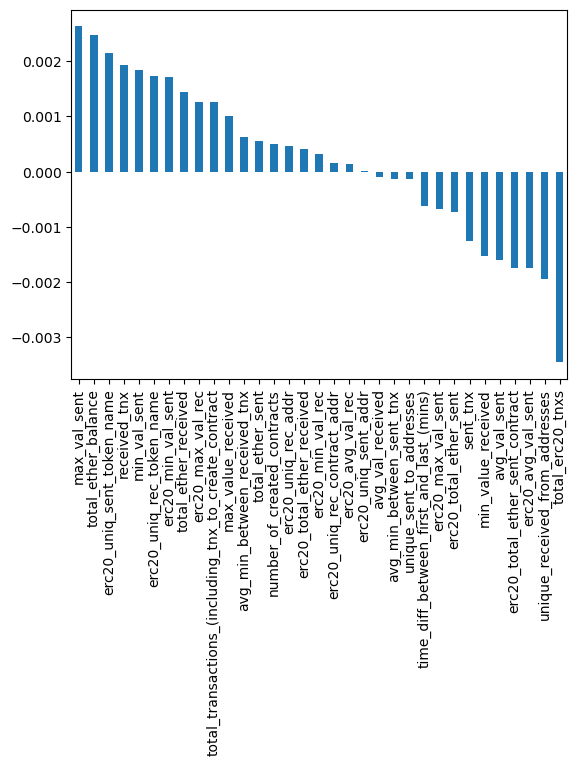

Norm of our average camouflage: 0.0055942 added to x in N~(0,1)
Attack succes rate: 20.11%


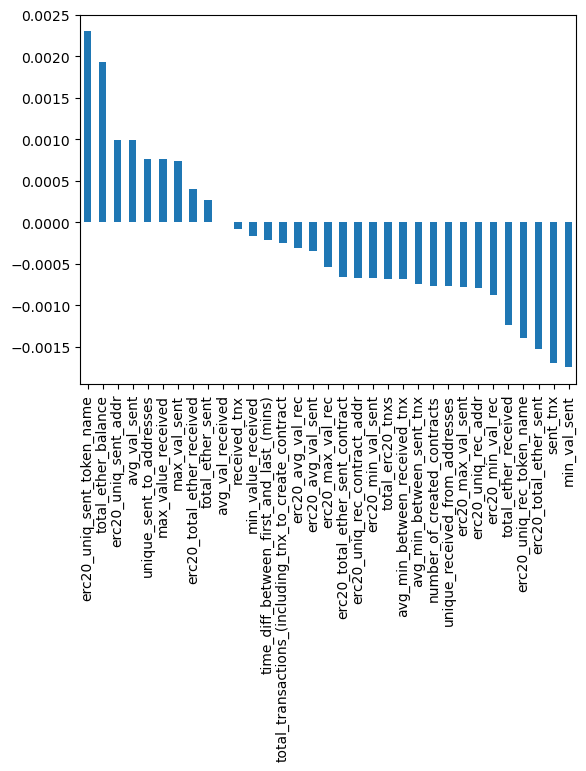

Norm of our average camouflage: 0.0011909 added to x in N~(0,1)
Attack succes rate: 16.20%


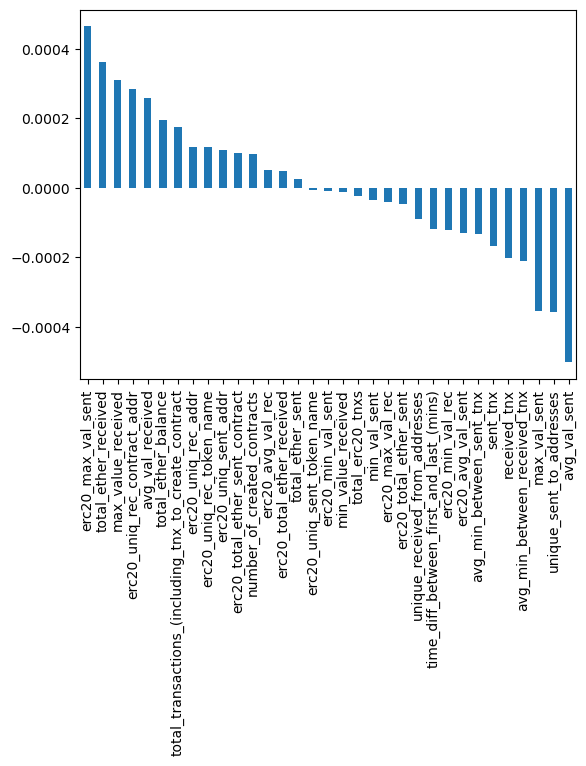

In [7]:
vals = [(1000,2500),(2000,2500),(5000,5000),(10000,5000),(100,50),(100,10)]
models = [AdvGAN.load_from_checkpoint("./models/AdvGAN78.ckpt"),AdvGAN.load_from_checkpoint("./models/AdvGAN20.ckpt"),AdvGAN.load_from_checkpoint("./models/AdvGANL16.ckpt")]
for model in models: 
    #model,trainer = train(AdvGAN(r=r,c=c))
    model.eval()
    good_camo = []
    flip=0
    total=0


    for x,y in test_data_loader:
        if(y==1):
            if(xgb_c.predict(x)==1): 
                total+=1
                x_y = torch.cat((x.view((x.size(0), -1)),y.view((y.size(0), -1))),dim=1)
                camo = model(x_y).detach()
                x = camo + x  
                if(xgb_c.predict(x)==0): 
                    flip+=1
                    good_camo.append(camo)


    flip_rate = flip/total
    camo_mean = 0
    for camo in good_camo:
        camo_mean+=camo.numpy()/len(good_camo)
    camo_mean = camo_mean[0]
    print("Norm of our average camouflage: "+f"{np.linalg.norm(camo_mean):.7f}" +" added to x in N~(0,1)")
    camo_mean=camo_mean+mean*0 

    print("Attack succes rate: "+f"{flip_rate*100:.2f}%")
    camo_mean.sort_values(ascending=False).plot.bar()
    plt.show()